In [1]:
# Tensorflow imports
# from tensorflow.test import is_gpu_available
from tensorflow.keras.models import Sequential, load_model, model_from_json, Model
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers, regularizers

# Sklearn imports
from sklearn.preprocessing import Normalizer, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Mongo
from pymongo import MongoClient

# Pandas and numpy
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(18, 4)})

# Hyperopt
from hyperopt import hp, fmin, tpe, STATUS_OK, STATUS_FAIL, Trials, space_eval, rand

# Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Other
from scipy.ndimage.filters import gaussian_filter1d
from IPython.display import Image
from datetime import datetime, timedelta
from math import sqrt

import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3" 

In [2]:
sns.set(rc={'figure.figsize':(18, 4)})

### Connect to mongo database

In [3]:
# Mongo client
client = MongoClient('mongodb://165.22.199.122:27017')
db = client.processed
data = db.internal

In [4]:
# Load the data
df= (pd.DataFrame(list(data.find()))
    .drop(['_id', 'window'], 1)
    .set_index('timestamp')
    .sort_index()
    .dropna())

df['price_diff'] = df['price'].diff(1)
df = df.dropna()
df = df[df['price_diff'].abs() < 40]
df = df[df['n_tweets'] >= 190]
df = df.iloc[3:-3]

print(df.shape)
df.head()

(5286, 4)


,n_tweets,price,sentiment,price_diff
timestamp,,,,
2019-11-03 14:58:00,316,9192.100,0.173610,2.921
2019-11-03 15:00:00,313,9195.474,0.163184,3.374
2019-11-03 15:02:00,385,9193.544,0.151912,-1.930
2019-11-03 15:04:00,429,9190.258,0.135992,-3.286
2019-11-03 15:06:00,473,9186.290,0.145232,-3.968


### Function to create timeline plot

In [5]:
def plot_timeline(first_feature, second_feature):
    sns.set_style("dark")
    
    fig, ax1 = plt.subplots()

    ax1.plot(df['2019-01-02 08:00:00':][first_feature], label=first_feature)
    ax1.legend(loc='upper left')
    ax2 = ax1.twinx()
    ax2.plot(df['2019-01-02 08:00:00':][second_feature], color='orange', label=second_feature)
    ax2.legend(loc='upper right')

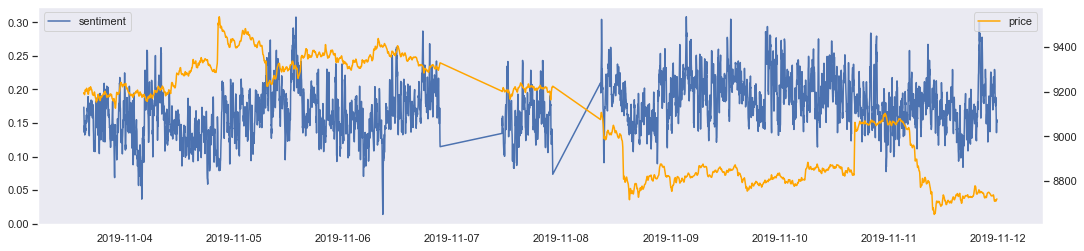

In [6]:
plot_timeline('sentiment', 'price')

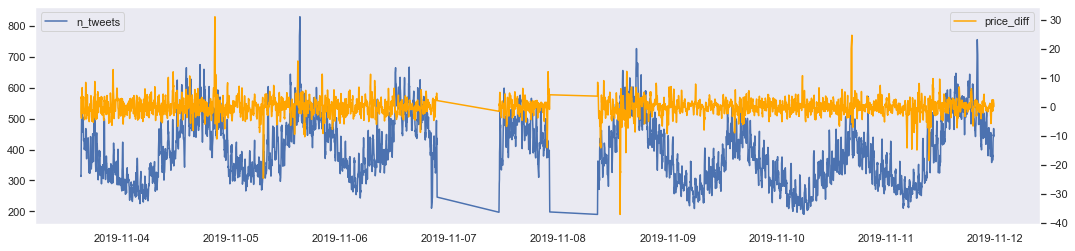

In [7]:
plot_timeline('n_tweets', 'price_diff')

### Prepare training data

In [8]:
df['price'].head()

timestamp
2019-11-03 14:58:00    9192.100
2019-11-03 15:00:00    9195.474
2019-11-03 15:02:00    9193.544
2019-11-03 15:04:00    9190.258
2019-11-03 15:06:00    9186.290
Name: price, dtype: float64

In [ ]:
split_sequence(df['price'], 3)

In [236]:
train_size = int(.75 * len(df))

price_diff = df['price_diff'].values
price_diff_train, price_diff_test = price_diff[:train_size], price_diff[train_size:]

sentiment = df['sentiment'].values
sentiment_train, sentiment_test = sentiment[:train_size], sentiment[train_size:]

n_tweets = df['n_tweets'].values
n_tweets_train, n_tweets_test = n_tweets[:train_size], n_tweets[train_size:]

data = np.stack([price_diff_train, sentiment_train, n_tweets_train], axis=1)

data_split = split_sequence(data, 12)

In [18]:
np.set_printoptions(suppress=True)

In [238]:
data_split[0].flatten('F')

array([ -3.0225    ,  -0.72916667,  -1.86333333,   3.374     ,
         2.288     ,   2.502     ,   2.921     ,   3.374     ,
        -1.93      ,  -3.286     ,  -3.968     ,   0.393     ,
         0.24112466,   0.25534524,   0.25383859,   0.21677549,
         0.21157235,   0.19037853,   0.17361044,   0.16318371,
         0.15191169,   0.13599184,   0.1452315 ,   0.1468129 ,
        73.        , 126.        , 184.        , 257.        ,
       311.        , 312.        , 316.        , 313.        ,
       385.        , 429.        , 473.        , 504.        ])

In [167]:
data_split.reshape(-1, 12*3, order='F')[0]

array([ -1.93      ,  -3.286     ,  -3.968     ,   0.393     ,
         4.168     ,   4.188     ,   5.621     ,   6.602     ,
         0.556     ,  -2.253     ,  -2.285     ,  -2.369     ,
         0.15191169,   0.13599184,   0.1452315 ,   0.1468129 ,
         0.13215627,   0.14367148,   0.15276477,   0.13937879,
         0.1348307 ,   0.14266518,   0.13861673,   0.15006024,
       385.        , 429.        , 473.        , 504.        ,
       558.        , 512.        , 474.        , 462.        ,
       456.        , 471.        , 490.        , 503.        ])

In [8]:
def split_sequence(sequence, n_steps):
    X = []
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence)-1:
            break
        seq_x = sequence[i:end_ix]
        X.append(seq_x)
        
    return np.array(X)

def generate_train_test(n_steps=12, train_size=.75, flatten=True):
    train_size = int(train_size * len(df))
    
    prices = df['price'].values
    prices_train, prices_test = prices[:train_size], prices[train_size:]
    
    price_diff = df['price_diff'].values
    price_diff_train, price_diff_test = price_diff[:train_size], price_diff[train_size:]
    
    sentiment = df['sentiment'].values
    sentiment_train, sentiment_test = sentiment[:train_size], sentiment[train_size:]
    
    n_tweets = df['n_tweets'].values
    n_tweets_train, n_tweets_test = n_tweets[:train_size], n_tweets[train_size:]
    
    train = np.stack([prices_train, sentiment_train, n_tweets_train], axis=1)
    test = np.stack([prices_test, sentiment_test, n_tweets_test], axis=1)
    
    # Scale the data
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(train)
    test_scaled = scaler.transform(test)
    scaler_mean = scaler.mean_
    scaler_var = scaler.var_
    
    # Create the sequence
    X_train = split_sequence(train, n_steps)
    X_test = split_sequence(test, n_steps)
    
    y_prices = df['price']

    y_train = y_prices.iloc[n_steps:len(X_train)+n_steps].values
    y_test = y_prices.iloc[-len(X_test):].values
    
    # Flatten the timeseries
    if flatten:
        X_train = X_train.reshape(-1, X_train.shape[1]*X_train.shape[2], order='F')
        X_test = X_test.reshape(-1, X_test.shape[1]*X_test.shape[2], order='F')
        
    return X_train, X_test, y_train, y_test, (scaler_mean, scaler_var)

In [9]:
X_train, X_test, y_train, y_test, scaler_values = generate_train_test(n_steps=3, flatten=True)
X_train.shape

(3961, 9)

In [10]:
X_train[0]

array([9.19210000e+03, 9.19547400e+03, 9.19354400e+03, 1.73610443e-01,
       1.63183706e-01, 1.51911688e-01, 3.16000000e+02, 3.13000000e+02,
       3.85000000e+02])

In [11]:
y_train[0]

9190.258

In [12]:
scaler_values

(array([9.14809815e+03, 1.71638227e-01, 4.06556004e+02]),
 array([5.29357681e+04, 1.64774550e-03, 9.19667068e+03]))

### Build the keras model

In [23]:
# model.add(BatchNormalization())
# model.add(Dropout(.65))
# model.add(Dense(41, activation='relu'))
# model.add(LSTM(32, activation='relu'))
# model.add(LSTM(64, activation='relu', input_shape=(n_steps, n_features), return_sequences=True))

In [104]:
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 

def build_lstm_model():
    model = Sequential()
    
    model.add(LSTM(32, activation='relu', input_shape=(3, 4)))
    model.add(Dense(16, activation='relu'))
    
    model.add(Dense(1))
    model.compile(optimizer='rmsprop', loss=root_mean_squared_error)
    
    return model

def build_model():
    model = Sequential()
    model.add(Dense(16, activation='relu', input_shape=(X_train.shape[1],), 
#                     kernel_regularizer=regularizers.l2(0.01)
                   ))
    
    model.add(Dense(8, activation='relu', 
#                     kernel_regularizer=regularizers.l2(0.01)
                   ))
        
    model.add(Dense(1))
    model.save('model')
    model.compile(optimizer='adam', loss=root_mean_squared_error)
    
    return model

In [105]:
# Create the model
model = build_model()
model.summary()

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=32)

# Checkpoints
checkpointer = ModelCheckpoint(filepath='models/keras_weights.hdf5',
                                   verbose=1,
                                   save_best_only=True)

# Fit the model
model.fit(
    X_train, 
    y_train, 
    validation_split=0.33,
    epochs=256, 
    batch_size=64,
    callbacks=[checkpointer, early_stopping]);

Model: "sequential_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_141 (Dense)            (None, 16)                160       
_________________________________________________________________
dense_142 (Dense)            (None, 8)                 136       
_________________________________________________________________
dense_143 (Dense)            (None, 1)                 9         
Total params: 305
Trainable params: 305
Non-trainable params: 0
_________________________________________________________________
Train on 2653 samples, validate on 1308 samples
Epoch 1/256
2176/2653 [=======================>......] - ETA: 0s - loss: 6439.6191 
Epoch 00001: val_loss improved from inf to 3797.46366, saving model to models/keras_weights.hdf5
2653/2653 [==============================] - 1s 227us/sample - loss: 6059.4861 - val_loss: 3797.4637
Epoch 2/256
1920/2653 [====================>.........] 

### Load model

In [106]:
def load_trained_model():
    model = build_model()
    model.load_weights('models/keras_weights.hdf5')
    
    return model

model = load_trained_model()

In [107]:
model.save('model')

In [108]:
import keras

In [109]:
keras.__version__

'2.3.1'

#### Baseline functions
* Roll - always predict previous price
* Zero - always predict zero

In [110]:
def rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

def predict_roll(data):
    return sqrt(mean_squared_error(np.roll(data, 1)[1:], data[1:]))

def predict_zero(data):
    return sqrt(mean_squared_error(np.zeros_like(data), data))

In [111]:
# Predict using the test data
y_hat = model.predict(X_test)
y_hat_train = model.predict(X_train)

In [112]:
# Test baseline
print('Test baseline roll: ${:.2f}'.format(predict_roll(y_test)))
print('Test baseline zero: ${:.2f}'.format(predict_zero(y_test)))
print('Test RMSE: ${:.2f}'.format(rmse(y_hat, y_test)))

Test baseline roll: $6.64
Test baseline zero: $8865.66
Test RMSE: $9.07


In [113]:
# Train baseline
print('Train baseline roll: ${:.2f}'.format(predict_roll(y_train)))
print('Train baseline zero: ${:.2f}'.format(predict_zero(y_train)))
print('Train RMSE: ${:.2f}'.format(rmse(y_hat_train, y_train)))

Train baseline roll: $4.85
Train baseline zero: $9150.96
Train RMSE: $7.17


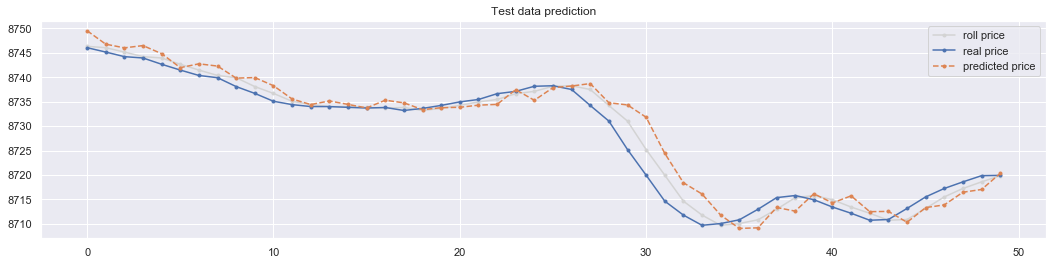

In [114]:
sns.set(style='darkgrid')
plt.plot(np.roll(y_test, 1)[-50:], label='roll price', color='lightgray', marker='o', markersize=3)
plt.plot(y_test[-50:], label='real price', marker='o', markersize=3)
plt.plot(y_hat[-50:], linestyle='dashed', label='predicted price', marker='o', markersize=3)
plt.title('Test data prediction')
plt.legend();

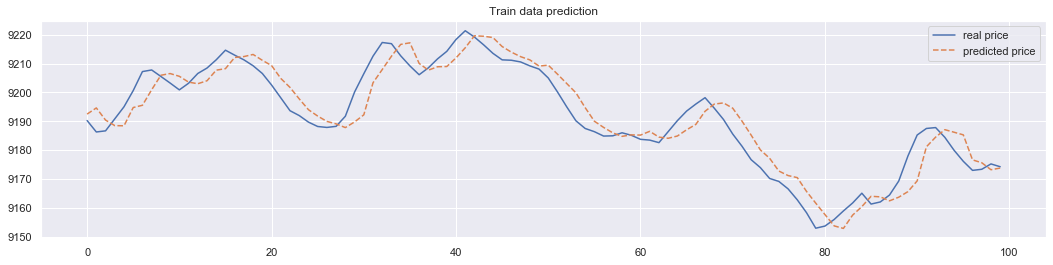

In [115]:
sns.set(style='darkgrid')
plt.plot(y_train[:100], label='real price')
plt.plot(y_hat_train[:100], linestyle='dashed', label='predicted price')
plt.title('Train data prediction')
plt.legend();

#### Hyperopt

In [89]:
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def build_model(dense_layers=2, dense_hidden_size=8, dropout_rate=0, l1_reg=0, l2_reg=0, 
                optimizer_function='adam', learning_rate=0.001, **arg):
    model = Sequential()
    model.add(Dense(dense_hidden_size, activation='relu', input_shape=(X_train.shape[1],),
                    kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)
                   ))
    model.add(Dropout(dropout_rate))
    
    for layer in range(dense_layers-1):
        model.add(Dense(dense_hidden_size, activation='relu', 
                        kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)
                       ))
        model.add(Dropout(dropout_rate))
        
    model.add(Dense(1))
    
    model.compile(optimizer=optimizer_function, loss=root_mean_squared_error)
    
    return model    

In [90]:
space = {'dense_layers': hp.choice('dense_layers', [1, 2]),
         
         'dense_hidden_size': hp.choice('dense_hidden_size', [8, 16, 32]),
         
         'regularization': hp.choice('regularization', 
                                     [{'reg_type': 'dropout',
                                       'dropout_rate': hp.choice('dropout_rate', [0.20, 0.35, 0.50])},
                                       {'reg_type': 'l1', 
                                        'l1_reg': hp.loguniform('l1_reg', -9, -2)}, 
                                       {'reg_type': 'l2', 
                                        'l2_reg': hp.loguniform('l2_reg', -9, -2)}]),
         
         'optimizer_function': hp.choice('optimizer_function', ['adam', 'RMSprop'])
        }

In [91]:
def hyperopt_wrapper(params):
    print('Params testing: ', params)
    
    model = build_model(**params)
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=32)
    
    checkpointer = ModelCheckpoint(filepath='models/keras_weights.hdf5',
                                   verbose=0,
                                   save_best_only=True)
    
    result = model.fit(X_train, 
                        y_train, 
                        verbose=0,
                        validation_split=0.33,
                        epochs=256, 
                        batch_size=64,
                        callbacks=[checkpointer, early_stopping])
    
    loss = np.amin(result.history['val_loss'])
    
    print('Best validation loss of epoch:', loss)
    return {'loss': loss, 'status': STATUS_OK, 'trained_model': model}  

In [92]:
trials = Trials()
best = fmin(hyperopt_wrapper, 
            space, 
            algo=tpe.suggest, 
            max_evals=15, 
            trials=trials)

Params testing:                                     
{'dense_hidden_size': 8, 'dense_layers': 1, 'optimizer_function': 'adam', 'regularization': {'l1_reg': 0.0031361025517894934, 'reg_type': 'l1'}}
Best validation loss of epoch:                      
7.038304242883618                                   
Params testing:                                                             
{'dense_hidden_size': 8, 'dense_layers': 1, 'optimizer_function': 'adam', 'regularization': {'l1_reg': 0.008096140648798635, 'reg_type': 'l1'}}
Best validation loss of epoch:                                              
7.884603942206146                                                           
Params testing:                                                             
{'dense_hidden_size': 32, 'dense_layers': 1, 'optimizer_function': 'adam', 'regularization': {'l2_reg': 0.04194263892736314, 'reg_type': 'l2'}}
Best validation loss of epoch:                                              
6.850904292652002      

In [93]:
best_model = trials.results[np.argmin([r['loss'] for r in trials.results])]['trained_model']

In [94]:
config = best_model.get_config()

In [95]:
model = Sequential.from_config(config)
model.compile(optimizer='adam', loss=root_mean_squared_error)

In [96]:
model.summary()

Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_128 (Dense)            (None, 16)                160       
_________________________________________________________________
dropout_79 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_129 (Dense)            (None, 16)                272       
_________________________________________________________________
dropout_80 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_130 (Dense)            (None, 1)                 17        
Total params: 449
Trainable params: 449
Non-trainable params: 0
_________________________________________________________________


In [97]:
result = model.fit(X_train, 
                   y_train, 
                   verbose=0,
                   epochs=256, 
                   batch_size=64,
                   callbacks=[checkpointer, early_stopping])

In [98]:
def rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

def predict_roll(data):
    return sqrt(mean_squared_error(np.roll(data, 1)[1:], data[1:]))

def predict_zero(data):
    return sqrt(mean_squared_error(np.zeros_like(data), data))

In [99]:
# Predict using the test data
y_hat = model.predict(X_test)
y_hat_train = model.predict(X_train)

In [100]:
# Test baseline
print('Test baseline roll: ${:.2f}'.format(predict_roll(y_test)))
print('Test baseline zero: ${:.2f}'.format(predict_zero(y_test)))
print('Test RMSE: ${:.2f}'.format(rmse(y_hat, y_test)))

Test baseline roll: $6.64
Test baseline zero: $8865.66
Test RMSE: $18.11


In [101]:
# Train baseline
print('Train baseline roll: ${:.2f}'.format(predict_roll(y_train)))
print('Train baseline zero: ${:.2f}'.format(predict_zero(y_train)))
print('Train RMSE: ${:.2f}'.format(rmse(y_hat_train, y_train)))

Train baseline roll: $4.85
Train baseline zero: $9150.96
Train RMSE: $17.33


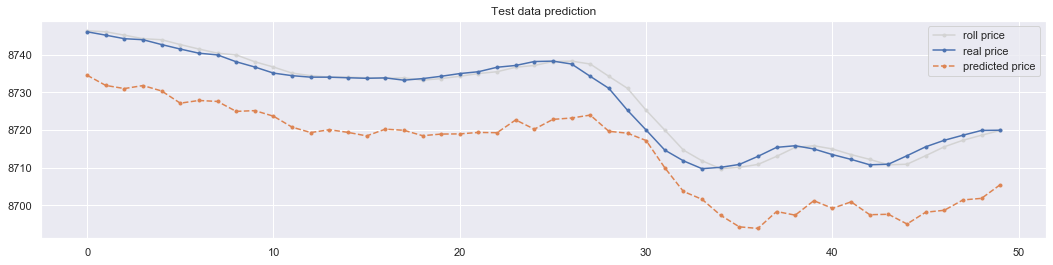

In [102]:
sns.set(style='darkgrid')
plt.plot(np.roll(y_test, 1)[-50:], label='roll price', color='lightgray', marker='o', markersize=3)
plt.plot(y_test[-50:], label='real price', marker='o', markersize=3)
plt.plot(y_hat[-50:], linestyle='dashed', label='predicted price', marker='o', markersize=3)
plt.title('Test data prediction')
plt.legend();

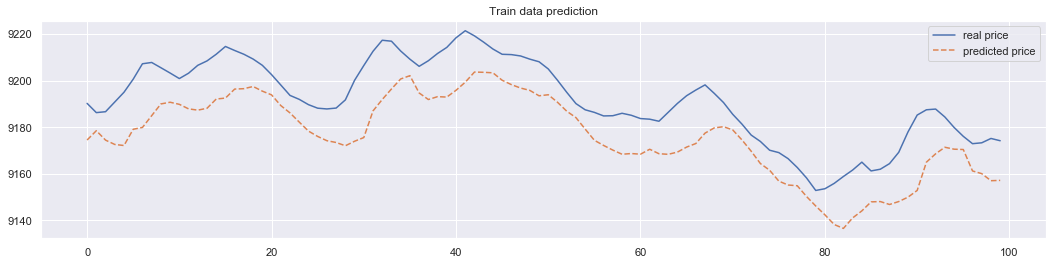

In [103]:
sns.set(style='darkgrid')
plt.plot(y_train[:100], label='real price')
plt.plot(y_hat_train[:100], linestyle='dashed', label='predicted price')
plt.title('Train data prediction')
plt.legend();

### XGBoost

In [307]:
from hyperopt import hp, fmin, tpe, STATUS_OK, STATUS_FAIL, Trials, space_eval, rand

In [281]:
# XGB parameters
xgb_reg_params = {
    'learning_rate':    hp.choice('learning_rate',    np.arange(0.05, 0.31, 0.05)),
    'max_depth':        hp.choice('max_depth',        np.arange(5, 16, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),
    'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.3, 0.8, 0.1)),
    'subsample':        hp.uniform('subsample', 0.8, 1),
    'objective':        'reg:squarederror',
    'n_estimators':     10000
}

xgb_fit_params = {
    'eval_metric': 'rmse',
    'early_stopping_rounds': 10,
    'verbose': False
}

xgb_data_params = {
    'n_steps': hp.choice('n_steps', np.arange(1, 24, 1, dtype=int)),
}

xgb_parameters = dict()
xgb_parameters['reg_params']  = xgb_reg_params
xgb_parameters['fit_params']  = xgb_fit_params
xgb_parameters['data_params'] = xgb_data_params

In [282]:
class Hyperopt():
    
    def process(self, fn_name, space, trials, algo, max_evals):
        fn = getattr(self, fn_name)
        try:
            result = fmin(fn=fn, space=space, algo=algo, max_evals=max_evals, trials=trials)
        except Exception as e:
            print({'status': STATUS_FAIL, 'exception': str(e)})
        else:
            return result, trials

    def xgb_regression(self, parameters):
        model = XGBRegressor(**parameters['reg_params'])
        return self.train(model, parameters)

    def train(self, model, parameters):
        X_train, X_test, y_train, y_test = generate_train_test(**parameters['data_params'])
        
        model.fit(X_train, y_train,
                eval_set=[(X_train, y_train), (X_test, y_test)],
                **parameters['fit_params'])
        
        y_hat = model.predict(X_test)
        loss = np.sqrt(mean_squared_error(y_test, y_hat))
        
        return {'loss': loss, 'status': STATUS_OK, 'model': model}

In [308]:
optimizer = Hyperopt()

best, trails = optimizer.process(
    fn_name='xgb_regression', 
    space=xgb_parameters, 
    trials=Trials(), 
    algo=rand.suggest,
    max_evals=20)

100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [01:29<00:00,  2.88s/it, best loss: 38.095362672543025]


In [309]:
def get_best_model(trails):
    best_idx = np.argmin([trail['result']['loss'] for trail in trails])
    return list(trails)[best_idx]['result']['model']

def get_best_data_params(parameters, best_params):
    return space_eval(parameters, best_params)['data_params']

In [310]:
data_params = get_best_data_params(xgb_parameters, best)

X_train, X_test, y_train, y_test = generate_train_test(**data_params)

In [311]:
xgboost = get_best_model(trails)

In [312]:
# Predict using the test data
y_hat = xgboost.predict(X_test)
y_hat_train = xgboost.predict(X_train)

In [313]:
# Test baseline
print('Test baseline roll: ${:.2f}'.format(predict_roll(y_test)))
print('Test baseline zero: ${:.2f}'.format(predict_zero(y_test)))
print('Test RMSE: ${:.2f}'.format(rmse(y_hat, y_test)))

Test baseline roll: $34.88
Test baseline zero: $5327.72
Test RMSE: $38.10


In [314]:
# Train baseline
print('Train baseline roll: ${:.2f}'.format(predict_roll(y_train)))
print('Train baseline zero: ${:.2f}'.format(predict_zero(y_train)))
print('Train RMSE: ${:.2f}'.format(rmse(y_hat_train, y_train)))

Train baseline roll: $116.47
Train baseline zero: $8599.96
Train RMSE: $76.55


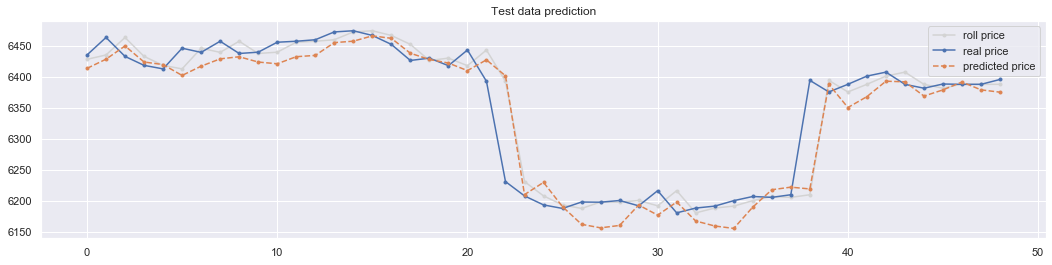

In [315]:
plt.plot(np.roll(y_test, 1)[1:50], label='roll price', color='lightgray', marker='o', markersize=3)
plt.plot(y_test[1:50], label='real price', marker='o', markersize=3)
plt.plot(y_hat[1:50], linestyle='dashed', label='predicted price', marker='o', markersize=3)
plt.title('Test data prediction')
plt.legend();

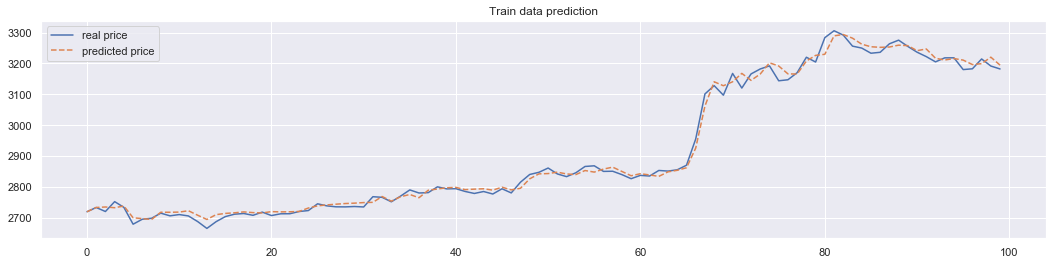

In [316]:
plt.plot(y_train[:100], label='real price')
plt.plot(y_hat_train[:100], linestyle='dashed', label='predicted price')
plt.title('Train data prediction')
plt.legend();